In [25]:
include("LazyMatrices.jl")
include("TurtleSearch.jl")
# using .LazyMatrices, .TurtleSearch
import .LazyMatrices as lm
import .TurtleSearch as tt

In [36]:
include("eom.jl")
import .GoldbergerWiseEoM as eom
# using .GoldbergerWiseEoM

In [26]:
using Plots, LaTeXStrings

In [27]:
function g2_m_perturb(l2, xrange, u=eom.u, k=eom.k, yₘ=eom.yₘ)
    g2s0 = exp10.(range(xrange..., 100))
    m2s0 = 4l2*(2k+u)*u^2/(3k)*(1-exp(2k*yₘ))/(1-exp((4k+2u)*yₘ)) * (1 .- (4k+2u) ./g2s0)
    ms0 = sqrt.(m2s0)
    return g2s0, ms0
end

g2_m_perturb (generic function with 4 methods)

In [70]:
function nextpose(poses, m)
    t = tt.Turtles(max(poses...))
    inds = tt.bisearch(t, m)
    xs = [m.xaxis(inds[1])]
    ys = [m.yaxis(inds[2])]
    while !isnothing(tt.next!(t, m))
        inds = tt.bisearch(t, m)
        push!(xs,m.xaxis(inds[1]))
        push!(ys,m.yaxis(inds[2]))
    end
    poses = tt.findfirstseed!(m, map(x->x+CartesianIndex(0,1), poses)...)
    return xs, ys, poses
end
function g2_m_numerical(l2, xrange, yrange, u=eom.u, k=eom.k, φP=1e-1; logscaled = true, nSeeds = 1)
    paramsearch_g2_m = eom.paramsearch(l2=l2, φP=φP)
    m = lm.LazyMatrix(zeros(100,100), paramsearch_g2_m, xrange, yrange, logscaled = logscaled)
    poses = tt.findfirstseed!(m, CartesianIndex(1, 1), CartesianIndex(1, 2))
    @assert !isnothing(poses) "no seed found"
    g2_m = []
    for i = 1:nSeeds
        g2s, ms, poses = nextpose(poses, m)
        push!(g2_m, (g2s, ms))
    end
    return g2_m
end

g2_m_numerical (generic function with 4 methods)

In [38]:
function getφ(m, l2, g2; FP=1., φP=1.)
    params = (m, l2, g2)
    Fsol = eom.solveODE(FP, φP, params)
    eom.getφ(Fsol, params)
end

getφ (generic function with 1 method)

In [30]:
function axis_scale(x)
    if abs(x)<=1
        return x
    elseif x>1
        return 1+log10(x)
    elseif x<1
        return -1-log10(-x)
    end
end

axis_scale (generic function with 1 method)

In [66]:
g2_m = g2_m_numerical(1e-3, (0, 4), (-10, 1), eom.u, eom.k, 1e-2, nSeeds=2)

poses = (CartesianIndex(1, 23), CartesianIndex(1, 24))
poses = tt.findfirstseed!(m, map((x->begin
                    #= /Users/outk/Documents/Codes/Julia/22-7/spectraShooter/deploy.v3.ipynb:11 =#
                    x + CartesianIndex(0, 1)
                end), poses)...) = 

(CartesianIndex(1, 55), CartesianIndex(1, 56))
poses = (CartesianIndex(1, 55), CartesianIndex(1, 56))
poses = tt.findfirstseed!(m, map((x->begin
                    #= /Users/outk/Documents/Codes/Julia/22-7/spectraShooter/deploy.v3.ipynb:11 =#
                    x + CartesianIndex(0, 1)
                end), poses)...) = 

(CartesianIndex(1, 58), CartesianIndex(1, 59))


2-element Vector{Any}:
 ([1.0, 1.0974987654930561, 1.2045035402587823, 1.321941148466029, 1.4508287784959397, 1.5922827933410924, 1.7475284000076838, 1.9179102616724886, 2.1049041445120205, 2.3101297000831598  …  14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708, 14.69934488822708], [3.372832637209938e-8, 3.372832637209938e-8, 3.372832637209938e-8, 3.372832637209938e-8, 3.3719900521351434e-8, 3.3719900521351434e-8, 3.3719900521351434e-8, 3.3711476775509614e-8, 3.3711476775509614e-8, 3.3703055134048154e-8  …  1.0e-9, 7.742636826811277e-10, 5.994842503189421e-10, 4.6415888336127727e-10, 3.593813663804626e-10, 2.782559402207126e-10, 2.1544346900318867e-10, 1.6681005372000558e-10, 1.2915496650148827e-10, 1.0e-10])
 ([1.0, 1.0974987654930561, 1.2045035402587823, 1.321941148466029, 1.4508287784959397, 1.5922827933410924, 1.7475284000076838, 1.9179102616724886, 2.10490414451

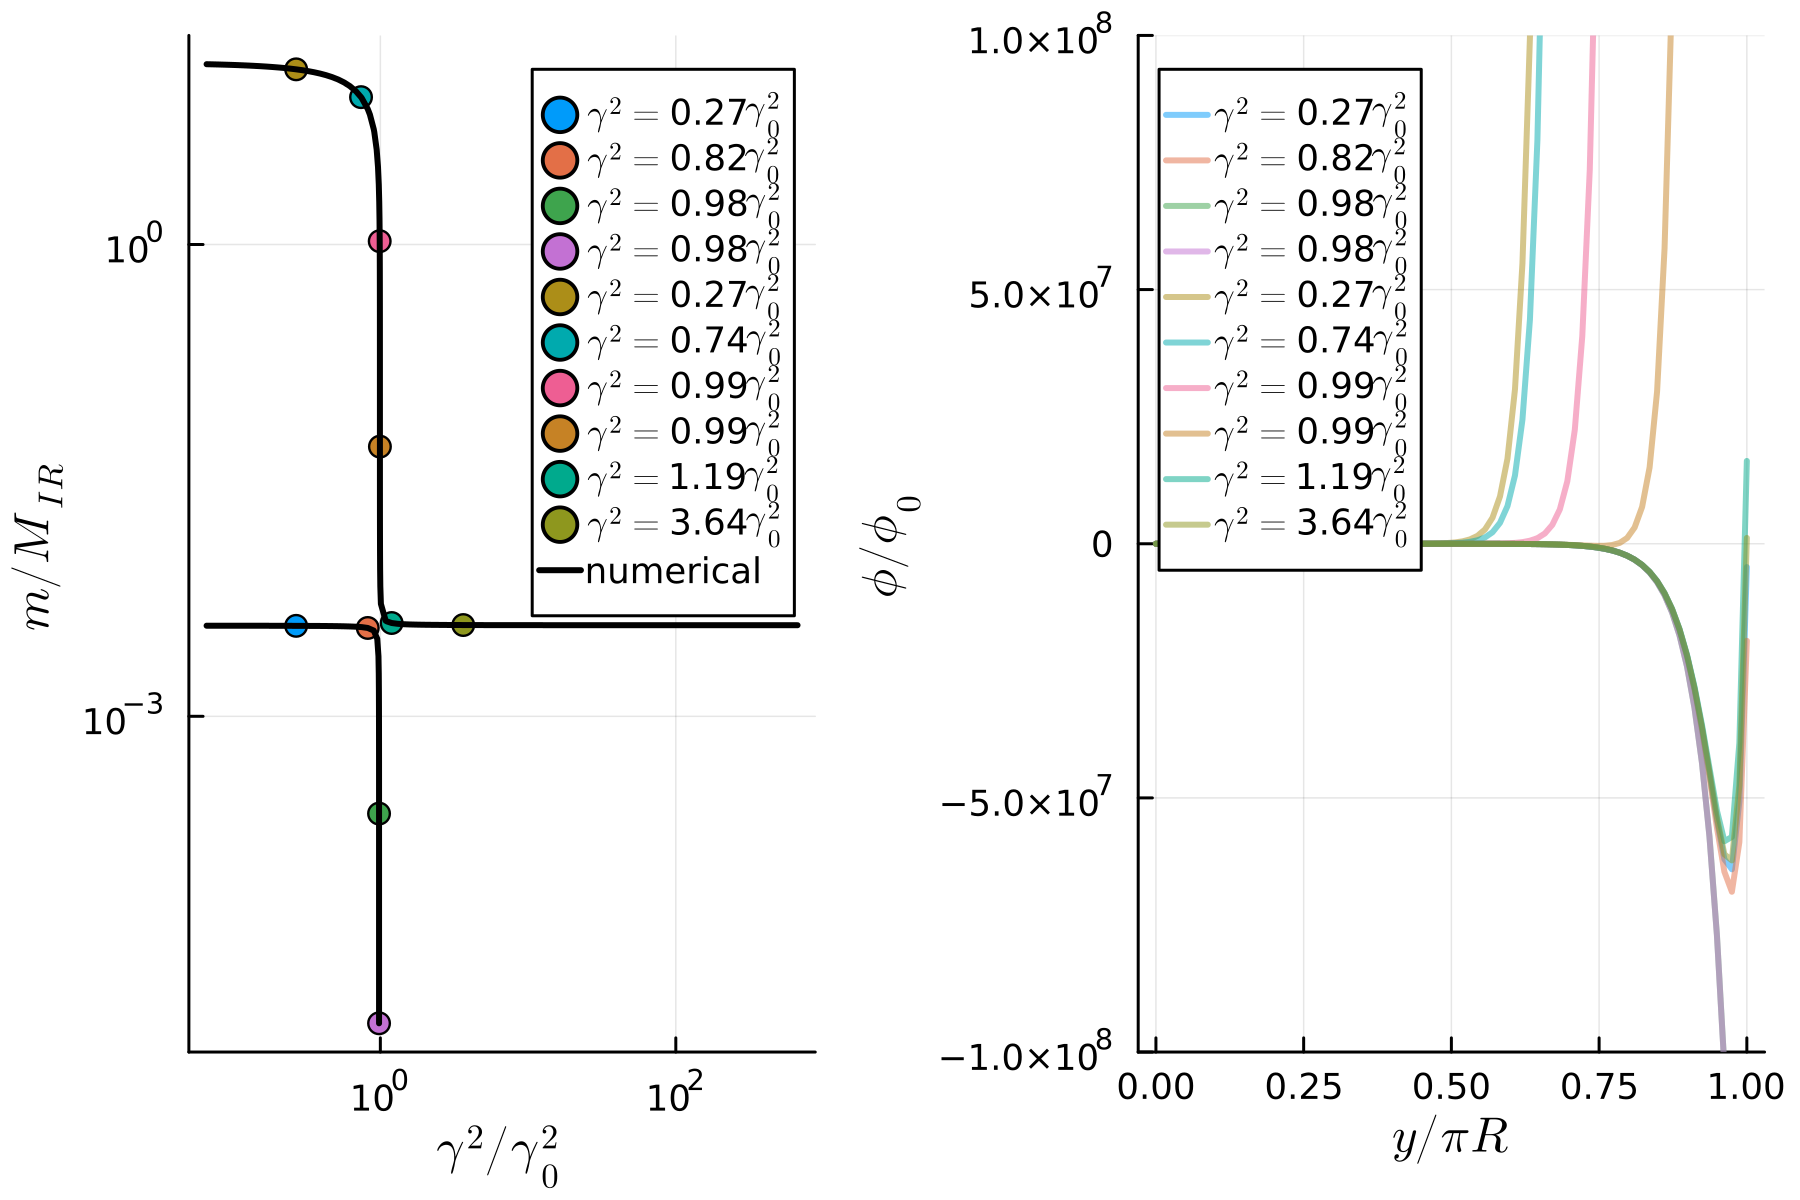

In [69]:
f1 = scatter()
f2 = plot(xlabel = L"y/\pi R", ylabel = L"\phi/\phi_0")
for (g2s, ms) in g2_m
    inds = findall(x-> 0.25eom.γ²₀ < x < 4eom.γ²₀, g2s)[1:12:end]
    
    for i in inds
        scatter!(f1, [g2s[i]/eom.γ²₀], [ms[i]/eom.M_IR], label = L"\gamma^2="*string(round(g2s[i]/eom.γ²₀, digits=2))*L"\gamma_0^2")
        φ(x) = getφ(ms[i], 1e-3, g2s[i])(x)
        plot!(f2, x-> (φ(π*x)+eom.ϕ0(π*x))/eom.ϕP, range(0,1,80), label = L"\gamma^2="*string(round(g2s[i]/eom.γ²₀, digits=2))*L"\gamma_0^2", lw=2, alpha=0.5, ylim=(-1e8,1e8))
    end
end
plot!(f1, g2_m[1]./[eom.γ²₀, eom.M_IR]..., label = "numerical", xlabel = L"\gamma^2/\gamma^2_0", ylabel = L"m/M_{IR}", legend = :topright, xaxis=:log10, yaxis=:log10, lw=2, c=:black)
plot!(f1, g2_m[2]./[eom.γ²₀, eom.M_IR]..., label = nothing, xlabel = L"\gamma^2/\gamma^2_0", ylabel = L"m/M_{IR}", legend = :topright, xaxis=:log10, yaxis=:log10, lw=2, c=:black)
# plot!(f1, g2_m_perturb(1e-3, (log10(eom.γ²₀)*(1+1e-3), 4))./[eom.γ²₀, eom.M_IR]..., label = "perturbative", lw=2, c=:black, ls=:dash)
f = plot!(f1, f2, layout = (1,2), dpi=300)
display(f)

┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580
┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580
┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580
┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580


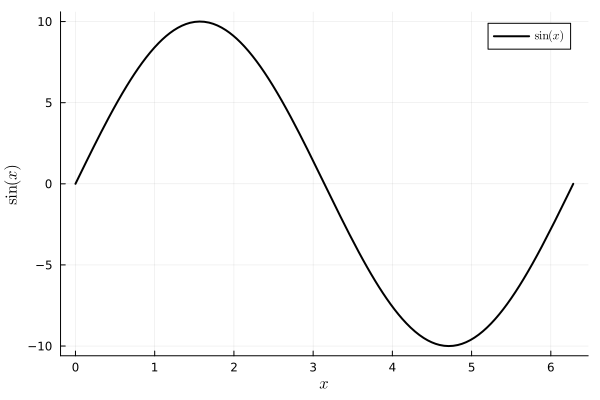

In [110]:
plot(x->10sin(x), 0, 2π, label = L"\sin(x)", xlabel = L"x", ylabel = L"\sin(x)", legend = :topright, lw=2, c=:black, scale=:asinh)

In [64]:
let 
    function f!(x)
        x = x+1
    end
    @show x = 1
    @show f!(x)
    @show x
end

x = 1 = 1
f!(x) = 2
x = 1

1

在 Julia 中，如果你想要在函数内部改变变量的值，你需要使用特殊的数据类型，如 Array 或者 Dict。对于基本数据类型（如 Int，Float），Julia 默认是不允许在函数内部改变它们的值的。但是，你可以通过返回新的值来实现这个效果。

以下是一个例子：



In [ ]:
let 
    function f!(x)
        x[1] = x[1] + 1
    end
    x = [1]
    @show x[1]
    f!(x)
    @show x[1]
end



在这个例子中，我们使用了一个单元素的 Array 来存储 x 的值。然后我们在函数 `f!` 中改变了这个 Array 的值。这样，函数 `f!` 就能够“就地”改变 x 的值了。